In [2]:
import pandas as pd
import json

In [3]:
def read_jsons(filedir:str):
    with open(filedir) as f:
        data = json.load(f)
    # Convert the JSON data to a DataFrame
    return pd.DataFrame.from_dict(data["playlists"])

# Filter Data

In [4]:
def get_count_artists(df: pd.DataFrame, bigger_than):
    artist_names = df["tracks"].apply(lambda x: [track["artist_name"] for track in x]).explode()
    artist_counts = artist_names.value_counts()
    return dict(artist_counts[artist_counts > bigger_than])

In [7]:
RANGE = range(0, 1000)
artist = dict()

for index in RANGE:
    df = read_jsons(f"../datasets/data/{index}.json")
    counts = get_count_artists(df, 10)
    for artist_name, count in counts.items():
        if artist_name in artist:
            artist[artist_name] += count
        else:
            artist[artist_name] = count
    del df

In [8]:
df = pd.DataFrame.from_dict(artist, orient='index', columns=["count"]).sort_values(by="count", ascending=False)
# df = pd.read_csv("../datasets/artist_count.csv")
df

,count
Drake,847160
Kanye West,413297
Kendrick Lamar,353624
Rihanna,339570
The Weeknd,316603
...,...
LA Priest,11
Julian Jordan,11
King James,11
Max Melvin,11


In [16]:
df.describe()

,count
count,25473.000000
mean,1827.298473
std,12745.446941
min,11.000000
25%,14.000000
50%,29.000000
75%,100.000000
max,847160.000000


<Axes: ylabel='Frequency'>

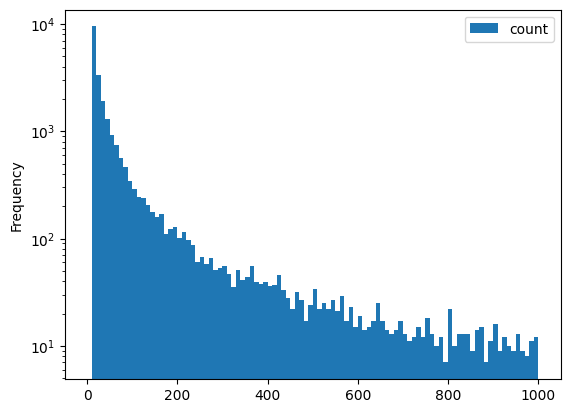

In [10]:
df.plot.hist(bins=100, range=(0, 1000), log=True)

<Axes: >

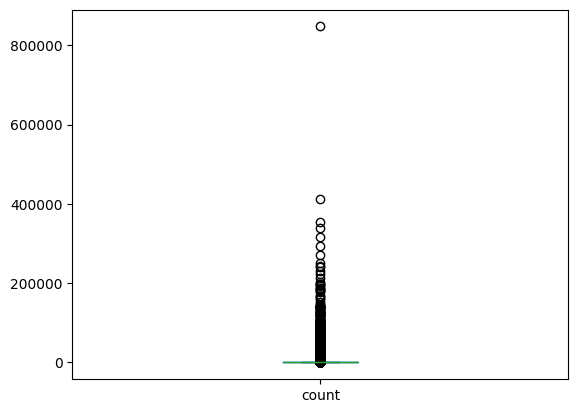

In [11]:
df.plot.box()

In [12]:
# calculate range interquartile
Q1 = df["count"].quantile(0.25)
Q3 = df["count"].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

Q1: 14.0, Q3: 100.0, IQR: 86.0


In [13]:
# get df without outliers
df_no_outliers = df[(df["count"] > (Q1 - 1.5 * IQR)) & (df["count"] < (Q3 + 1.5 * IQR))]

<Axes: ylabel='Frequency'>

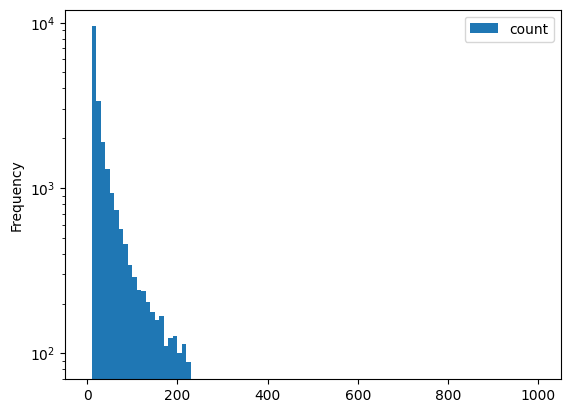

In [19]:
df_no_outliers.plot.hist(bins=100, range=(0, 1000), log=True)

In [14]:
df_no_outliers.describe()

,count
count,21245.000000
mean,40.828524
std,43.628038
min,11.000000
25%,13.000000
50%,23.000000
75%,48.000000
max,228.000000


In [21]:
df.to_csv("../datasets/artist_count.csv")

# Get data


In [22]:
def get_set_artists(df: pd.DataFrame, bigger_than):
    artist_names = df["tracks"].apply(lambda x: [track["artist_name"] for track in x]).explode()
    artist_counts = artist_names.value_counts()
    return artist_counts[artist_counts > bigger_than].index

In [23]:
def save_csv(file: int, filename: str, edges: list):
    print("Saving file", file)
    # Save the filein csv in format of edges
    # user , song_name
    dp = pd.DataFrame(edges, columns=["node_1", "node_2"])
    # delimeter ;
    dp.to_csv(f"../datasets/edges/{filename}-{file}.csv", index=False, sep=";",header = False)
    del dp

## Edges between Artists

In [28]:
edges = list()
RANGE = range(0, 1001)
names = set(df_no_outliers.index)

def get_edges_artists(filename: str):
    for file in RANGE:
        if file % 250 == 0 and file != 0:
            save_csv(file, filename, edges)
            edges.clear()
            if file == 1000:
                return
        print("Reading file", file)
        df: pd.DataFrame = read_jsons(f"../datasets/data/{file}.json")
        # Seleccionar la mitad
        df = df.sample(frac=0.1)
        for _, row in df.iterrows():
            songs = row["tracks"]
            j = 1
            for song_a in songs:
                if j == len(songs):
                    break
                if song_a["artist_name"] != songs[j]["artist_name"] and song_a["artist_name"] in names or songs[j]["artist_name"] in names:
                    edges.append(
                        (
                            song_a["artist_name"]
                            .strip()
                            .replace(";", ",")
                            .replace(" ", "_")
                            .replace("$", "S"),
                            songs[j]["artist_name"]
                            .strip()
                            .replace(";", ",")
                            .replace(" ", "_")
                            .replace("$", "S"),
                        )
                    )
                j += 1

In [ ]:
get_edges_artists("Artist")